# Exploratory data analysis

In [1]:
PATH_TO_CODE = '/User/pritigupta/desktop/Satsure/pastis-benchmark/code/' 
PATH_TO_PASTIS = 'data/PASTIS'

import sys
sys.path.append(PATH_TO_CODE)
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import json
import seaborn as sns

GeoJSON is a format for encoding geographic data structures. It supports point, line, polygon, multi-point, multi-line, and multi-polygon features.

Here's a breakdown of the structure:

1. **type**: This denotes the type of GeoJSON (e.g., "FeatureCollection").

2. **features**: This is a list where each entry is a geographic feature (e.g., a polygon, point, etc.)
    - **id**: A unique identifier for the feature.
    
    - **type**: The type of the feature (e.g., "Feature").

    - **properties**: Contains metadata about the feature. `Fold`, `ID_PATCH`, `N_Parcel`, `Parcel_Cover`, `TILE`, etc. and a series of dates (`dates-S2`) are present.

    - **geometry**: Describes the shape of the feature.
        - **type**: The type of the geometry (e.g., "Polygon", "Point").
        - **coordinates**: This is the list of coordinates that define the shape. For instance, if `type` is "Polygon", coordinates will be a list of points that define the boundary of the polygon.


3. **crs**: Specifies the Coordinate Reference System (CRS) for the GeoJSON data.

    - **type**: The type of CRS (e.g., "name").
    - **properties**: Contains the actual name or definition of the CRS (e.g., "EPSG:4326" for WGS 84).



In [2]:
# load the json file
with open('../data/PASTIS/metadata.geojson', 'r') as f:
    geojson_data = json.load(f)

In [3]:
import geopandas as gpd
gdf = gpd.read_file('../data/PASTIS/metadata.geojson')
gdf.head()

,Fold,ID_PATCH,N_Parcel,Parcel_Cover,TILE,dates-S2,id,geometry
0,1,10000,119,0.808032,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10000,"MULTIPOLYGON (((391504.736 6956805.915, 392781..."
1,2,10001,111,0.501986,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10001,"MULTIPOLYGON (((367628.562 6880296.822, 368905..."
2,4,10002,131,0.638722,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10002,"MULTIPOLYGON (((388950.375 6957003.181, 390227..."
3,5,10003,75,0.866824,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10003,"MULTIPOLYGON (((455228.326 6917189.740, 456504..."
4,4,10004,46,0.204906,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10004,"MULTIPOLYGON (((364779.509 6910052.243, 366056..."


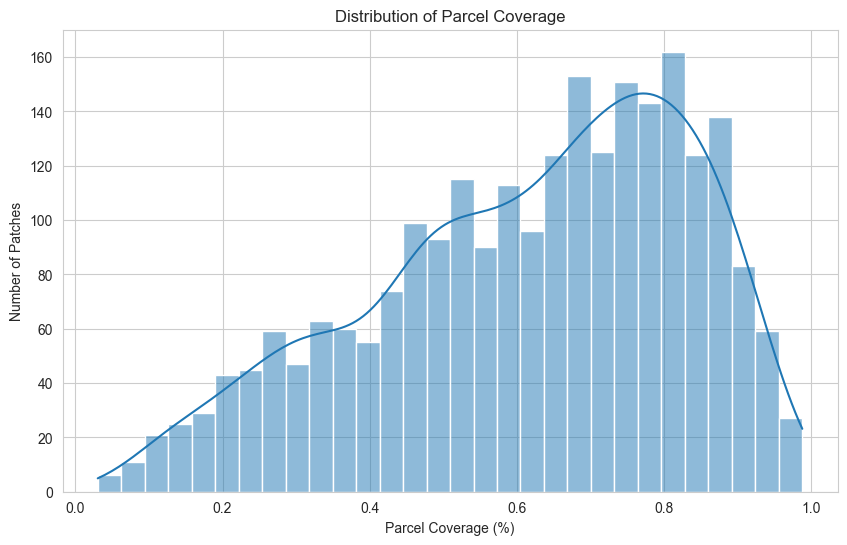

In [4]:
# parcel coverage plot

# Setting the style for the visualization
sns.set_style("whitegrid")

# Plotting the histogram for Parcel_Cover
plt.figure(figsize=(10, 6))
sns.histplot(gdf['Parcel_Cover'], bins=30, kde=True)
plt.title("Distribution of Parcel Coverage")
plt.xlabel("Parcel Coverage (%)")
plt.ylabel("Number of Patches")
plt.show()


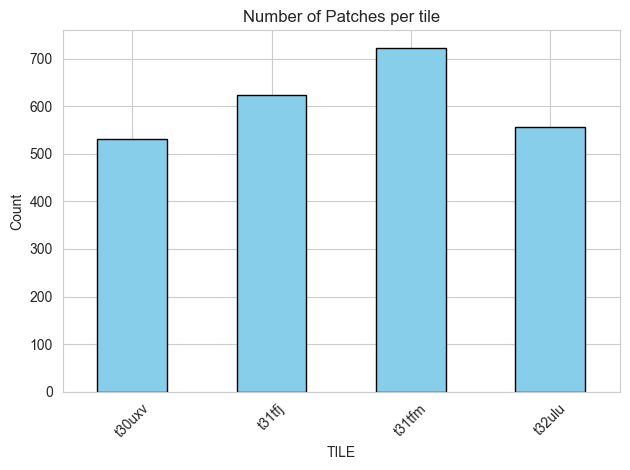

In [5]:
# Plot to count number of patches from each tile
tile_counts = gdf.groupby('TILE')['ID_PATCH'].count()

# Plotting
tile_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Patches per tile')
plt.xlabel('TILE')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


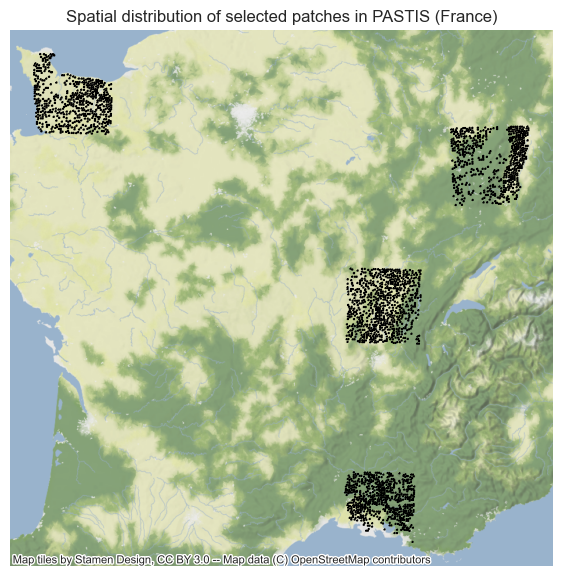

In [6]:
import contextily as ctx

# Load the dataframe into a GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Convert the GeoDataFrame to Web Mercator projection (required for contextily)
gdf = gdf.to_crs(epsg=3857)

# Set up the plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_aspect('equal', 'box')

# Plot the patches (polygons)
gdf.plot(ax=ax, edgecolor='k', facecolor='none')

# Adjust plot limits to focus on the main area of France where patches are present
# Setting a manual limit.
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin-50000, xmax+50000)  # Adjust as per your requirement
ax.set_ylim(ymin-50000, ymax+50000)  # Adjust as per your requirement

# Add the geographic map of France beneath the polygons using contextily
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground)

ax.set_title("Spatial distribution of selected patches in PASTIS (France)")
ax.axis('off')
plt.show()


/var/folders/_j/v313hjfd57bb0h0l_zx_wnt00000gn/T/ipykernel_44704/3058982265.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


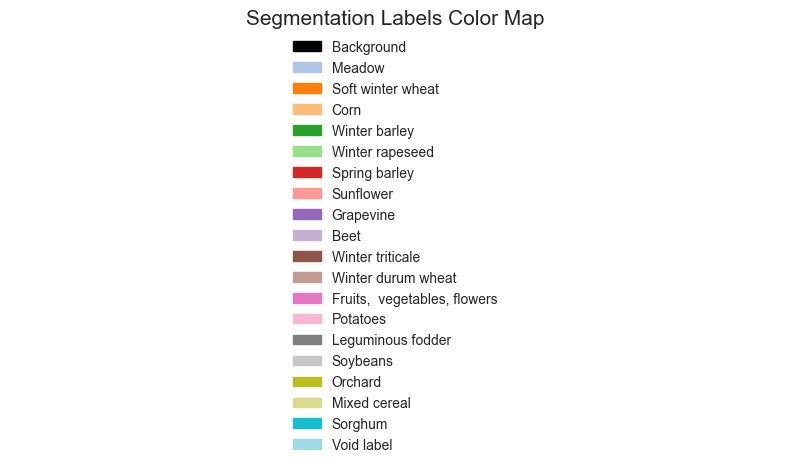

In [7]:
import matplotlib.patches as mpatches

# Your provided color map and labels
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']

with open('label_names.json', 'r') as f:
    labels = json.load(f)

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cus_colors[int(k)], label=labels[k]) for k in labels]
fig, ax = plt.subplots(figsize=(8, 5))
# Plot the legend
#plt.figure(figsize=(8, 5))
ax.axis('off')
ax.legend(handles=patches, loc='center', frameon=False, fontsize=10)
ax.set_title("Segmentation Labels Color Map", fontsize=15)
plt.tight_layout()
plt.show()

fig.savefig('colormap_legend.png', dpi=300, bbox_inches='tight')

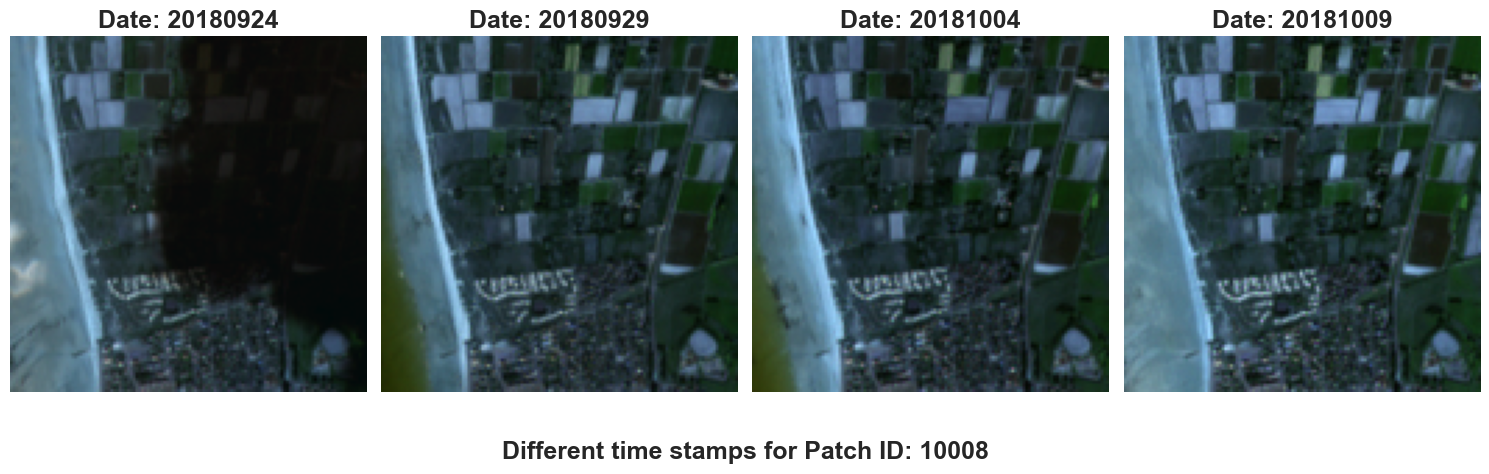

In [8]:
# visualising the time evolution of patches
def plot_patch_images(patch_id,pathname,num_timestamps=None,):
    """
    Plots the satellite images for a specific patch ID with dates as the title.
    
    Args:
    - patch_id (int): ID of the patch to visualize
    - num_timestamps (int, optional): Number of timestamps to display. If not provided, all timestamps for the patch will be shown.
    """
    
    # Load the JSON data
    with open(pathname, 'r') as f:
        data = json.load(f)
    
    # Find the dates for the specified patch ID
    for feature in data['features']:
        if feature['properties']['ID_PATCH'] == patch_id:
            dates = list(feature['properties']['dates-S2'].values())
            break
    else:
        print(f"Patch ID {patch_id} not found in the JSON data.")
        return
    
    # Restrict the number of dates if specified
    if num_timestamps:
        dates = dates[:num_timestamps]

    img =  np.load(f'../data/PASTIS/DATA_S2/S2_{patch_id}.npy')
    
    # Check if the image has the expected shape
    if img.shape != (43, 10, 128, 128):
        print(f"Unexpected image shape for Patch ID {patch_id}. Expected (43, 10, 128, 128) but got {img.shape}.")
        return
    
        # Plotting
    fig, axs = plt.subplots(1, len(dates), figsize=(15, 5))
    
    for idx, (ax, date) in enumerate(zip(axs, dates)):
        # Extract RGB channels for the specified timestamp using idx
        rgb_img = img[idx, :3, :, :].transpose(1, 2, 0)  # Transpose to 128,128,3 for plotting
        # Normalize the image to [0, 1] for visualization
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        ax.imshow(rgb_img)
        ax.axis('off')
        ax.set_title('Date: '+str(date),fontsize=18,fontweight='bold')
    
    # Add a common caption at the bottom of the figure
    fig.text(0.5, 0.01, 'Different time stamps for Patch ID: ' + str(patch_id), ha='center', fontsize=18, fontweight='bold')

    plt.tight_layout()
    plt.show()
    #fig.savefig(f'timeevol_{patch_id}.png', dpi=800, bbox_inches='tight')

# Call the function for patch ID 1001 and display images for the first 3 timestamps
plot_patch_images(10008, pathname='../data/PASTIS/metadata.geojson',num_timestamps=4)


Interpreting heatmaps for channels other than RGB in satellite imagery requires understanding the context and nature of the data, as well as the specifics of the application. Here's a general guide to interpreting heatmaps for satellite imagery channels:

1. **Color Scale**: The color scale on a heatmap typically ranges from cool colors (like blue) to warm colors (like red). The coolest color represents the minimum value in the data, and the warmest color represents the maximum value. A colorbar, usually placed beside the heatmap, indicates the numerical value associated with each color.

2. **Brightness/Intensity**: Areas of the heatmap that are brighter or have warmer colors correspond to higher values in the data. Conversely, areas that are darker or have cooler colors correspond to lower values.

3. **Spatial Patterns**: Look for spatial patterns or anomalies in the heatmap. For satellite imagery, these patterns can indicate:
   - **Vegetation Health**: Infrared channels often help in assessing vegetation health. Healthy vegetation may reflect more infrared light than unhealthy or sparse vegetation.
   - **Moisture Content**: Some channels can capture moisture content in the soil or vegetation.
   - **Land Use**: Differences in reflectance can indicate different types of land use, such as urban areas, water bodies, farmland, etc.
   - **Temperature Differences**: Thermal channels can capture temperature variations on the Earth's surface.

4. **Temporal Patterns** (if you're comparing multiple heatmaps over time): Look for changes over time in the same location. This can help in identifying temporal trends or anomalies.

5. **Comparison with RGB**: Comparing other channels' heatmaps with RGB images can provide context. For instance, a bright spot in an infrared heatmap might correspond to a forested area in an RGB image, indicating dense and healthy vegetation.

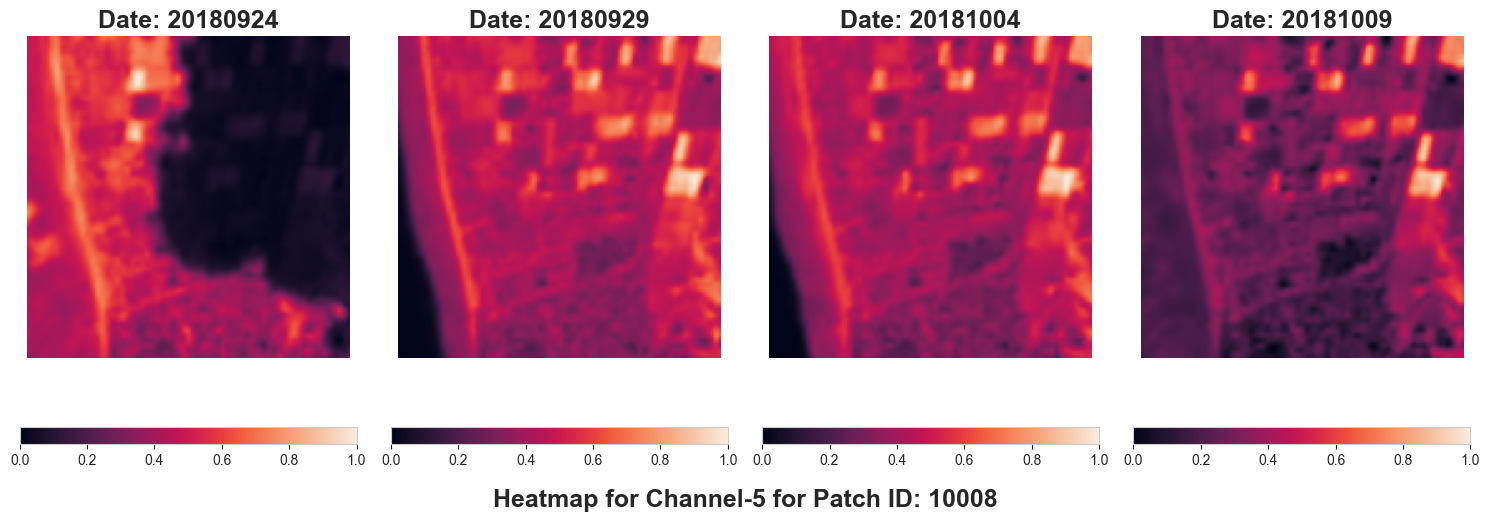

In [163]:
# visualising channels other than RGB using heatmaps

def plot_patch_images_HM(patch_id,channel, pathname,num_timestamps=None):
    """
    Plots the satellite images for a specific patch ID with dates as the title.
    """
    
    # Load the JSON data
    with open(pathname, 'r') as f:
        data = json.load(f)
    
    # Find the dates for the specified patch ID
    for feature in data['features']:
        if feature['properties']['ID_PATCH'] == patch_id:
            dates = list(feature['properties']['dates-S2'].values())
            break
    else:
        print(f"Patch ID {patch_id} not found in the JSON data.")
        return
    
    # Restrict the number of dates if specified
    if num_timestamps:
        dates = dates[:num_timestamps]

    img = np.load(f'../data/PASTIS/DATA_S2/S2_{patch_id}.npy')
    
    # Check if the image has the expected shape
    if img.shape != (43, 10, 128, 128):
        print(f"Unexpected image shape for Patch ID {patch_id}. Expected (43, 10, 128, 128) but got {img.shape}.")
        return
    
    # Plotting
    fig, axs = plt.subplots(1, len(dates), figsize=(15, 5))
    
    for idx, (ax, date) in enumerate(zip(axs, dates)):
        # Extract the 4th channel for the specified timestamp using idx
        channel_img = img[idx, channel, :, :]
        
        # Normalize the image to [0, 1] for visualization
        channel_img_normalized = (channel_img - channel_img.min()) / (channel_img.max() - channel_img.min())
        
        # Plot with default colormap to get heatmap-like visualization
        cax = ax.imshow(channel_img_normalized)  
        
        fig.colorbar(cax, ax=ax, orientation='horizontal')  # Add colorbar to illustrate value mapping
        ax.axis('off')
        ax.set_title('Date: ' + str(date), fontsize=18, fontweight='bold')
    
    # Add a common caption at the bottom of the figure
    fig.text(0.5, 0.01, 'Heatmap for Channel-'+str(channel)+' for Patch ID: ' + str(patch_id), ha='center', fontsize=18, fontweight='bold')

    plt.tight_layout()
    plt.show()
    fig.savefig(f'timeevol_{patch_id}_channel_{channel}.png', dpi=800, bbox_inches='tight')

# Call the function for patch ID 1001 and display images for the first 3 timestamps
plot_patch_images_HM(10008,5,pathname='../data/PASTIS/metadata.geojson',num_timestamps=4)


/var/folders/_j/v313hjfd57bb0h0l_zx_wnt00000gn/T/ipykernel_99310/2766625969.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


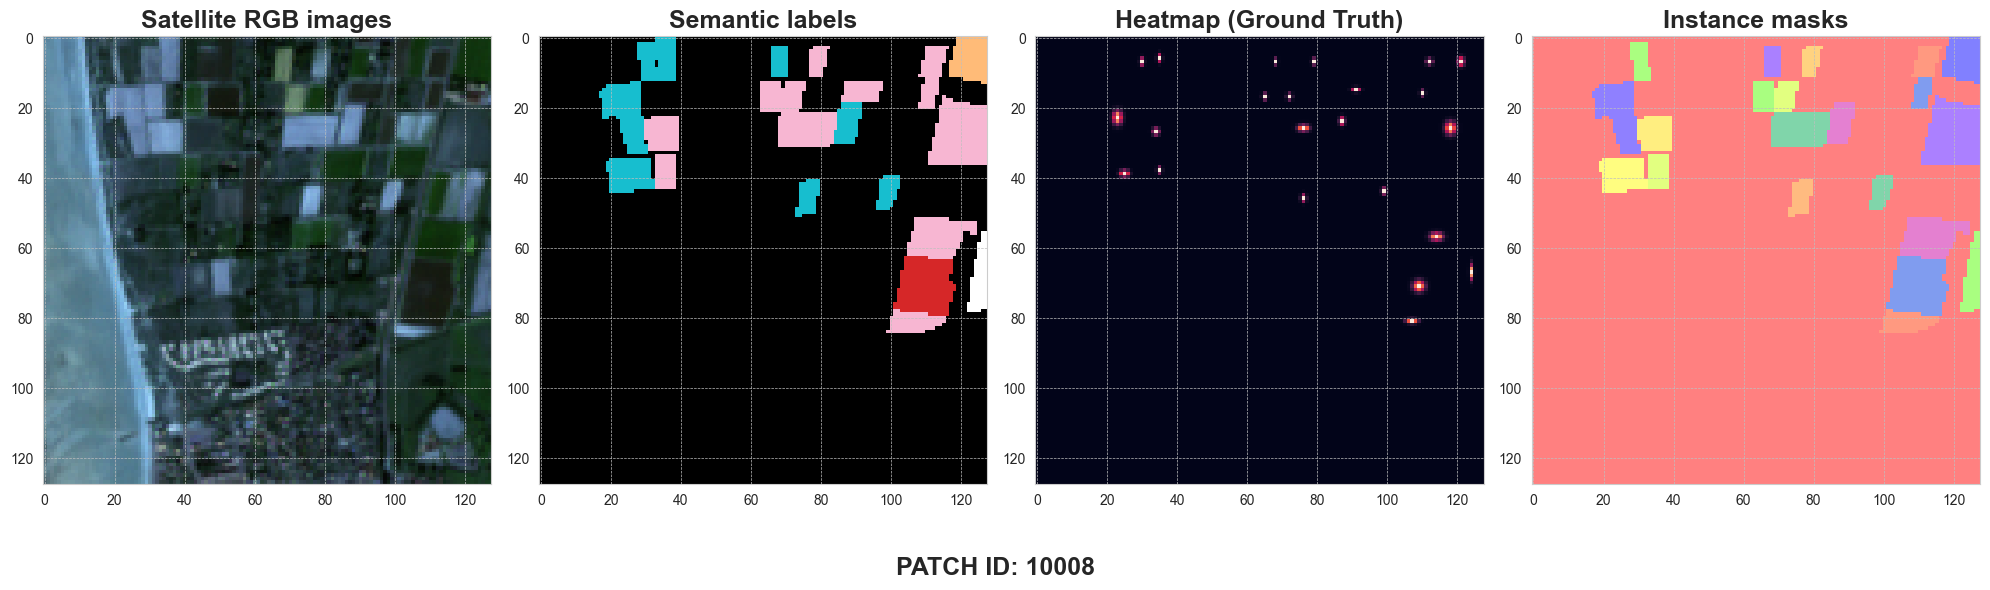

In [213]:
# making original and semantic maps side by side

def plot_satellite_and_labels(patch_id, timestamp_idx):
    # Load the satellite image based on patch_id
    time_series = np.load(f'../data/PASTIS/DATA_S2/S2_{patch_id}.npy')
    
    # Extract RGB channels for the given timestamp index
    def get_rgb(time_series):
        return time_series[timestamp_idx, :3, :, :].transpose(1, 2, 0)

    # Normalize the RGB image to [0, 1] for visualization
    rgb_img = get_rgb(time_series)
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
    
    # Load the semantic labels based on patch_id
    semantic_target = np.load(f'../data/PASTIS/ANNOTATIONS/TARGET_{patch_id}.npy')[0, :, :]

    # Load the instance segmentation data (assuming it's in a file named "INSTANCE_XXXXX.npy")
    instance_segmentation = np.load(f'../data/PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_{patch_id}.npy')
    
    # Load the heatmap (assuming it's in a file named "HEATMAP_XXXXX.npy")
    heatmap = np.load(f'../data/PASTIS/INSTANCE_ANNOTATIONS/HEATMAP_{patch_id}.npy')
    
    # Normalize the heatmap for visualization
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Define the custom colormap for semantic labels
    cm = matplotlib.cm.get_cmap('tab20')
    def_colors = cm.colors
    cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
    semantic_cmap = ListedColormap(colors=cus_colors, name='agri', N=21)

    # Plotting
    f, axs = plt.subplots(1, 4, figsize=(20, 7))
    
    axs[0].imshow(rgb_img)
    axs[0].set_title('Satellite RGB images', fontsize=18, fontweight='bold')
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='0.75')
    
    axs[1].imshow(semantic_target, cmap=semantic_cmap, vmin=0, vmax=19)
    axs[1].set_title('Semantic labels', fontsize=18, fontweight='bold')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='0.75')

    axs[2].imshow(heatmap)
    axs[2].set_title('Heatmap (Ground Truth)', fontsize=18, fontweight='bold')
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5, color='0.75')

    axs[3].imshow(instance_segmentation, cmap='prism',alpha=0.5)
    axs[3].set_title('Instance masks', fontsize=18, fontweight='bold')
    axs[3].grid(True, which='both', linestyle='--', linewidth=0.5, color='0.75')
    f.text(0.5, 0.05, 'PATCH ID: ' + str(patch_id), ha='center', fontsize=18, fontweight='bold')  # Adjust the y-coordinate as needed

    plt.tight_layout()
    plt.show()
    f.savefig(f'ori_sem_hm_{patch_id}.png', dpi=800, bbox_inches='tight')

# Usage example:
patch_id = 10008  # Replace with desired patch ID
timestamp_idx = 3  # Replace with desired timestamp index
plot_satellite_and_labels(patch_id, timestamp_idx)


# Temporal Data Analysis

In [9]:
# extracting time varations of pixels

import geopandas as gpd
gdf = gpd.read_file('../data/PASTIS/metadata.geojson')
gdf.columns

Index(['Fold', 'ID_PATCH', 'N_Parcel', 'Parcel_Cover', 'TILE', 'dates-S2',
       'id', 'geometry'],
      dtype='object')

In [10]:

import os

def load_satellite_images(gdf, folder="../data/PASTIS/DATA_S2", num_images=None):
    all_images = []

    # Use the provided number of images or all if not specified
    patch_ids = gdf['ID_PATCH'].tolist()
    if num_images:
        patch_ids = patch_ids[:num_images]
    
    # Iterate through the selected patch_ids to load images
    for patch_id in patch_ids:
        file_path = os.path.join(folder, f"S2_{patch_id}.npy")
        image = np.load(file_path)
        all_images.append(image)
    return np.array(all_images)

# Load only a specific number of images. For example, 50.
num_images_to_load = 1
satellite_images = load_satellite_images(gdf, num_images=num_images_to_load)


def extract_pixel_timeseries_for_each_image(satellite_images):
    n, t, c, h, w = satellite_images.shape
    
    # A dictionary to store pixel time series for each image
    all_pixel_data = {}
    
    for img_index in range(n):
        pixel_timeseries = {}
        for i in range(h):
            for j in range(w):
                # Extract time series for each pixel for the given image index
                pixel_timeseries[(i,j)] = satellite_images[img_index, :, :, i, j]
        all_pixel_data[img_index] = pixel_timeseries
    
    return all_pixel_data

pixel_data = extract_pixel_timeseries_for_each_image(satellite_images)




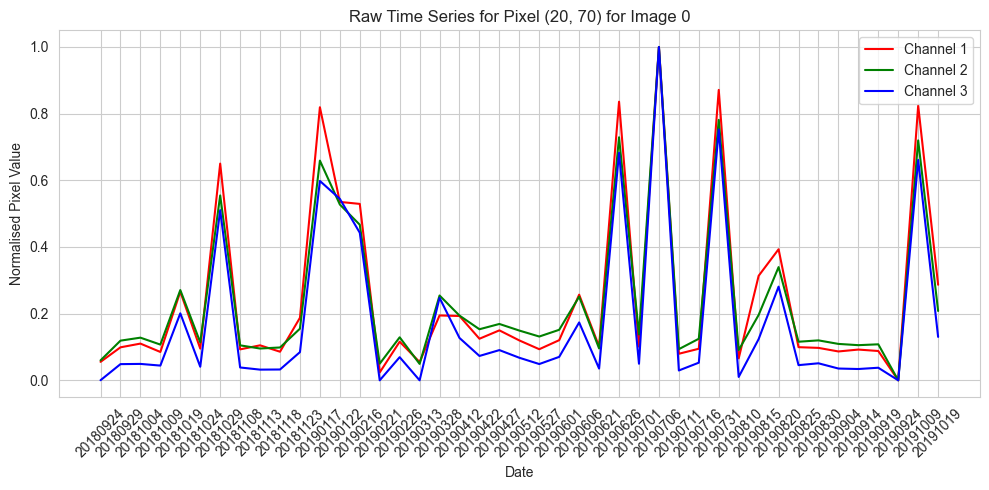

In [11]:
def plot_raw_timeseries(all_pixel_data, image_index, pixel_coord, dates, channel_indices=[0, 1, 2]):
    pixel_timeseries = all_pixel_data[image_index]
    series = pixel_timeseries[pixel_coord]
    
    # Convert numerical dates to string format
    str_dates = [str(date) for date in dates]
    
    plt.figure(figsize=(10,5))
    
    colors = ['r', 'g', 'b']
    for i, channel_index in enumerate(channel_indices):
        series_channel = series[:, channel_index]
        # Min-Max normalization
        min_val = series_channel.min()
        max_val = series_channel.max()
        normalized_series = (series_channel - min_val) / (max_val - min_val)
        
        plt.plot(str_dates, normalized_series, color=colors[i], label=f"Channel {channel_index + 1}")
    
        #plt.plot(str_dates, series_channel, color=colors[i], label=f"Channel {channel_index + 1}")
    
    plt.title(f"Raw Time Series for Pixel {pixel_coord} for Image {image_index}")
    plt.xlabel("Date")
    plt.ylabel("Normalised Pixel Value")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

index_im = 0
dates = list(gdf['dates-S2'][index_im].values())
# Example to plot time series for pixel (50,50) of the 0-th image for channels 0, 1, and 2:
plot_raw_timeseries(pixel_data, index_im, (20,70), dates)


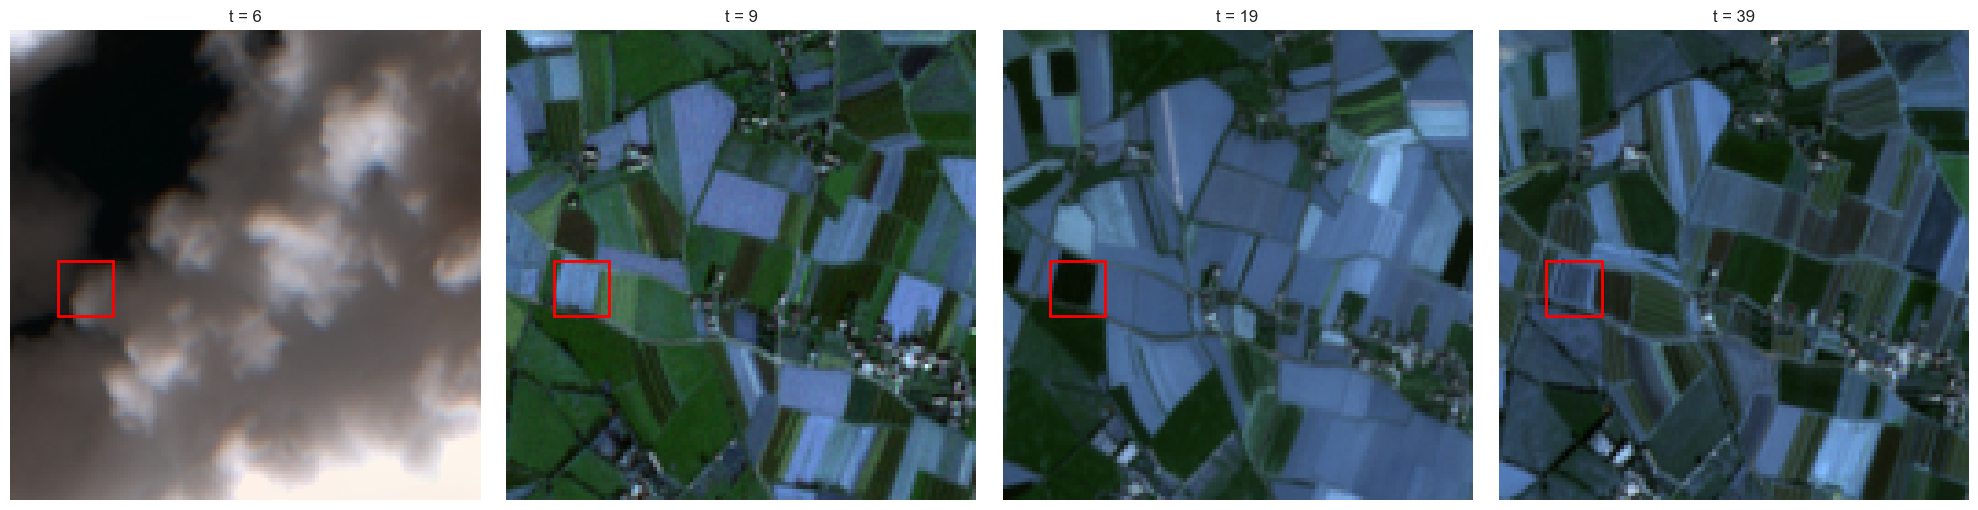

In [12]:
from matplotlib.patches import Rectangle
def plot_slices(satellite_images, t_slices, pixel_coord):
    num_slices = len(t_slices)
    fig, axes = plt.subplots(1, num_slices, figsize=(5*num_slices, 5))
    
    for i, t_idx in enumerate(t_slices):
        image = satellite_images[0, t_idx, :3, :, :]
        normalized_image = (image - image.min()) / (image.max() - image.min())
        
        axes[i].imshow(normalized_image.transpose(1, 2, 0))
        box_size = 15  # or any desired size
        linewidth_value = 2  # adjust as needed for boundary thickness

        rect = Rectangle((pixel_coord[0]-box_size/2, pixel_coord[1]-box_size/2), box_size, box_size, edgecolor='red', facecolor='none', linewidth=linewidth_value)
        axes[i].add_patch(rect)     
        axes[i].set_title(f"t = {t_idx}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Slices you want to visualize
t_slices = [6, 9, 19,39]

# Plotting the images for the desired slices
plot_slices(satellite_images, t_slices, (20, 70))


Here are the insights that can be derived from temporal analysis:

1. **Cloud Cover Detection**: Peaks in the time series graph, particularly for all RGB channels, often indicate the presence of clouds. This is because clouds reflect a lot of sunlight, leading to higher values in satellite images across most visible bands.

2. **Bare or Barren Land**: A noticeable dip in the green band while other bands remain relatively stable might indicate areas where there is little to no vegetation. The land appearing grey could be indicative of barren land, possibly due to reasons like fallow periods in agriculture, recent harvesting, or non-arable areas.

3. **Vegetation Health and Growth**: A rise in the green band is typically associated with areas of healthy vegetation or crop growth. This is because healthy plants and crops reflect more green light.

4. **Multitemporal Analysis**: Observing these patterns over time (multitemporal analysis) provides vital information regarding the land's use, crop cycles, growth patterns, and the impact of any interventions or changes in land management practices.

5. **Potential Applications**:
   - **Agriculture**: The presence of green can be used to assess crop health, determine optimal harvest times, and even predict yields. The absence or reduction of green can provide early warnings about potential crop failures.
   - **Land Cover Classification**: This analysis can be foundational in classifying different land cover types, especially distinguishing between vegetated and non-vegetated areas.
   - **Weather Impact**: The presence of clouds on specific dates provides clues about weather conditions and can be used in conjunction with meteorological data to understand local climate patterns or validate weather predictions.

6. **Caveats & Further Exploration**:
   - **Cloud Shadows**: While clouds show high reflectance, their shadows might cause lower reflectance values which can be mistaken for other features. It's crucial to account for these when interpreting satellite imagery.

In conclusion, the analysis of time-series satellite imagery at the pixel level offers valuable insights into land cover changes, vegetation health, and other environmental factors. The interplay of RGB channels and their variation over time can serve as a robust tool for monitoring and decision-making in various domains, from agriculture to environmental conservation.